<a href="https://colab.research.google.com/github/wcjona/BMEN_415_Final_Project/blob/main/Image_Classification/DRL_Epoch1-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install deeplake;

In [58]:
import deeplake
from PIL import Image
import numpy as np
import os, time
import torch
from torchvision import transforms, models

In [59]:
ds_train = deeplake.load('hub://activeloop/chest-xray-train')
ds_test = deeplake.load('hub://activeloop/chest-xray-test')
# https://datasets.activeloop.ai/docs/ml/datasets/chest-x-ray-image-dataset/

/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/chest-xray-train



|

hub://activeloop/chest-xray-train loaded successfully.



\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/chest-xray-test



|

hub://activeloop/chest-xray-test loaded successfully.



In [60]:
tform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((255,255), antialias=True),
    transforms.Grayscale(1),
])

In [61]:
train_loader = ds_train.pytorch(num_workers=0, transform = {'images': tform, 'labels': None}, batch_size=4, shuffle=True, decode_method={"images": "pil"})
test_loader = ds_test.pytorch(num_workers=0,  transform = {'images': tform, 'labels': None}, batch_size=4, shuffle=True, decode_method={"images": "pil"})

In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cpu


In [63]:
# Options for models: 
# https://pytorch.org/vision/stable/models.html
# RESNET18: Deep Residual Learning
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Convert model to grayscale
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Update the fully connected layer based on the number of classes in the dataset
model.fc = torch.nn.Linear(model.fc.in_features, len(ds_train.labels.info.class_names))

model.to(device)

# Specity the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)

In [64]:
def train_model(model, optimizer, data_loader, device):

    model.train()

    running_loss = 0.0
    total = 0
    correct = 0
    
    for i, data in enumerate(data_loader):
        start_time = time.time()
        # get the inputs; data is a list of [inputs, labels]
        inputs = data['images']
        labels = torch.squeeze(data['labels'])

        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
    
        if i % 100 == 0:    # print every 10 batches
            batch_time = time.time()
            speed = (batch_time-start_time)
            print('[%5d] loss: %.3f, speed: %.2f, accuracy: %.2f %%' %
                  (i, running_loss, speed, accuracy))

            running_loss = 0.0
            total = 0
            correct = 0
    print('Finished Training')

In [65]:
y_pred = []
y_true = []

def test_model(model, data_loader):
    model.eval()

    start_time = time.time()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # get the inputs; data is a list of [inputs, labels]
            inputs = data['images']
            labels = torch.squeeze(data['labels'])

            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs.float())

            _, predicted = torch.max(outputs.data, 1)
            y_pred.extend(predicted.data.cpu().numpy())
            y_true.extend(labels)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            if i % 10 == 0: 
              print(f"Current Accuracy: {accuracy}")

        print('Finished Testing')
        print('Testing accuracy: %.1f %%' %(accuracy))

In [66]:
epoch = 3
for i in range(epoch):
  train_model(model, optimizer, train_loader, device)
  test_model(model, test_loader)
  print(f'Finished Training for epoch #{i}')

[    0] loss: 0.000, speed: 5.01, accuracy: 75.00 %
[  100] loss: 0.000, speed: 1.23, accuracy: 56.25 %
[  200] loss: 0.000, speed: 2.26, accuracy: 53.50 %
[  300] loss: 0.000, speed: 1.51, accuracy: 55.00 %
[  400] loss: 0.000, speed: 1.31, accuracy: 53.25 %
[  500] loss: 0.000, speed: 1.27, accuracy: 55.75 %
[  600] loss: 0.000, speed: 1.28, accuracy: 68.75 %
[  700] loss: 0.000, speed: 1.27, accuracy: 64.25 %
[  800] loss: 0.000, speed: 1.26, accuracy: 59.00 %
[  900] loss: 0.000, speed: 1.27, accuracy: 59.75 %
[ 1000] loss: 0.000, speed: 1.23, accuracy: 62.00 %
[ 1100] loss: 0.000, speed: 1.30, accuracy: 63.50 %
[ 1200] loss: 0.000, speed: 1.71, accuracy: 60.50 %
[ 1300] loss: 0.000, speed: 1.27, accuracy: 60.50 %
Finished Training
Current Accuracy: 50.0
Current Accuracy: 54.54545454545455
Current Accuracy: 67.85714285714286
Current Accuracy: 66.93548387096774
Current Accuracy: 60.97560975609756
Current Accuracy: 65.19607843137256
Current Accuracy: 59.83606557377049
Current Accurac

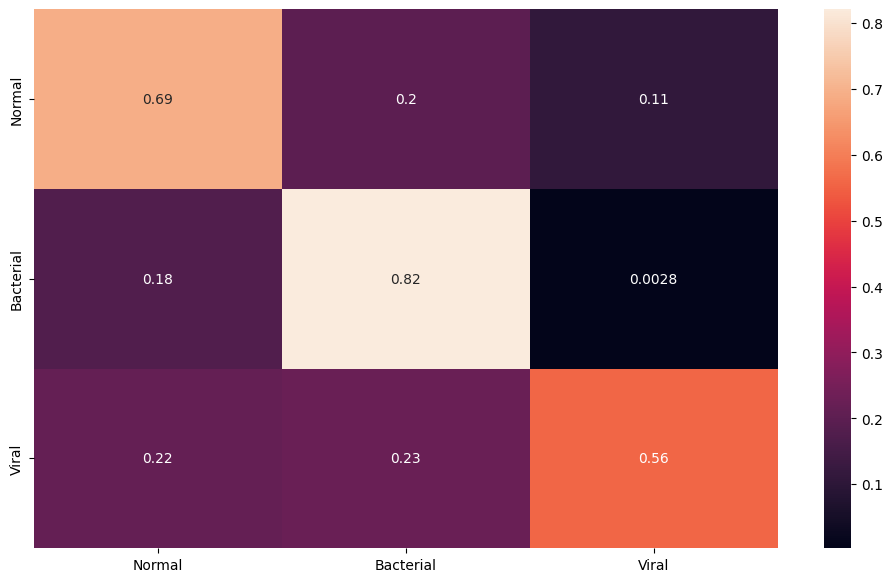

In [67]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

# constant for classes
classes = ('Normal', 'Bacterial', 'Viral')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')